In [1]:
import pandas as pd
from nebulagraph_lite import nebulagraph_let as ng_let
import os, math, torch
from tqdm.notebook import tqdm

from llama_index.core.schema import NodeRelationship, TextNode, RelatedNodeInfo
from llama_index.graph_stores.nebula import NebulaPropertyGraphStore
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from transformers import AutoTokenizer
from llama_index.core import (
    PropertyGraphIndex,
    
    Settings
)

# generate embeddings for all nodes to then create the index
from typing import Sequence
from llama_index.core.schema import BaseNode, MetadataMode
from llama_index.core.embeddings.utils import resolve_embed_model
from llama_index.core.settings import Settings

In [ ]:
# load NebulaGraph JupyterNotebook extension
!udocker pull vesoft/nebula-metad:v3
!udocker create --name=nebula-metad vesoft/nebula-metad:v3
!udocker setup --execmode=F1 nebula-metad
!udocker pull vesoft/nebula-graphd:v3
!udocker create --name=nebula-graphd vesoft/nebula-graphd:v3
!udocker setup --execmode=F1 nebula-graphd
!udocker pull vesoft/nebula-storaged:v3
!udocker create --name=nebula-storaged vesoft/nebula-storaged:v3
!udocker setup --execmode=F1 nebula-storaged

n = ng_let(in_container=True)
n.start() # This takes around 5 mins


In [2]:
%reload_ext ngql
%ngql --address 127.0.0.1 --port 9669 --user root --password nebula


[OK] Connection Pool Created


,Name
0,PrimeKG
1,basketballplayer


# Create the graph from NebulaGraph directly

In [5]:
#primekg = pd.read_csv("~/scratch-llm/data/PrimeKG_data/raw_data/kg.csv", low_memory=False)
nodes = pd.read_csv("~/scratch-llm/data/PrimeKG_data/raw_data/nodes.csv",
    low_memory=False,
    sep=',',
    quotechar='"',  
    escapechar='\\', 
)

edges = pd.read_csv("~/scratch-llm/data/PrimeKG_data/raw_data/edges.csv")

## Nodes

In [ ]:
print(nodes['node_type'].unique()) #types of nodes

In [6]:
# save the data for each 'node_type' in a separate file
for node_type in nodes['node_type'].unique():
    sanitized_node_type = node_type.replace('/', '_')
    output_path = os.path.join('~/scratch-llm/data/PrimeKG_data/sub_data/', 'node_'+ sanitized_node_type + '.csv')
    nodes[nodes['node_type'] == node_type].to_csv(output_path, index=False)

In [227]:
# Create Tags (node_type) for each node in the PrimeKG
%ngql CREATE TAG IF NOT EXISTS anatomy(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS gene_protein(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS drug(node_name string, node_source string, node_id string, description string, half_life string, indication string, mechanism_of_action string, protein_binding string, pharmacodynamics string, state string, atc_1 string, atc_2 string, atc_3 string, atc_4 string, category string, group string, pathway string, molecular_weight string, tpsa string, clogp string);
%ngql CREATE TAG IF NOT EXISTS disease(node_name string, node_source string, mondo_id int, mondo_name string, group_id_bert string, group_name_bert string, mondo_definition string, umls_description string, orphanet_definition string, orphanet_prevalence string, orphanet_epidemiology string, orphanet_clinical_description string, orphanet_management_and_treatment string, mayo_symptoms string, mayo_causes string, mayo_risk_factors string, mayo_complications string, mayo_prevention string, mayo_see_doc string);
%ngql CREATE TAG IF NOT EXISTS pathway(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS biological_process(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS effect_phenotype(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS molecular_function(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS cellular_component(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS exposure(node_name string, node_source string, node_id string);

""


In [ ]:
# Load each node source data into the corresponding Tag (working fine)
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_gene_protein.csv --tag gene_protein --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_biological_process.csv --tag biological_process --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_effect_phenotype.csv --tag effect_phenotype --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_molecular_function.csv --tag molecular_function --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_cellular_component.csv --tag cellular_component --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_pathway.csv --tag pathway --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_exposure.csv --tag exposure --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_anatomy.csv --tag anatomy --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source


### Extra information for nodes 'drug' and 'disease'

In [ ]:
# disease and drug feature files are available as .tab format so they need to be converted to .csv
# many formatting issues on both files that had to be correcteed manually before merging with the 'node_' dataset
disease_tab = "~/scratch-llm/data/PrimeKG_data/raw_data/disease_features.tab"
drug_tab = "~/scratch-llm/data/PrimeKG_data/raw_data/drug_features.tab"

df = pd.read_csv(disease_tab, delimiter='\t')
disease_csv = "~/scratch-llm/data/PrimeKG_data/sub_data/disease_features.csv"
df.to_csv(disease_csv, index=False)


df = pd.read_csv(drug_tab, delimiter='\t')
drug_csv = "~/scratch-llm/data/PrimeKG_data/sub_data/drug_features.csv"
df.to_csv(drug_csv, index=False) 

In [10]:
# merge extra drug and disease information 
node_drug = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_drug.csv")
features_drug = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/drug_features.csv")
node_disease = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_disease.csv")
features_disease = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/disease_features.csv")


In [11]:
# the disease_features has multiple rows with the same 'node_index' so we need to merge them
def merge_column_values(column):
    # Check if all values in the column can be converted to float
    try:
        numeric_column = pd.to_numeric(column, errors='coerce')
        if numeric_column.notna().all():  # If all are numbers, return unique values
            return '; '.join(map(str, sorted(set(numeric_column))))  # Keep the first numeric value (assuming they're the same)
    except Exception:
        pass
    
    # For strings, concatenate unique, non-empty values
    return '; '.join(filter(lambda x: pd.notna(x) and str(x).strip() != '', set(column)))

merged_features_disease = features_disease.groupby('node_index', as_index=False).agg(merge_column_values)

In [ ]:
# Merge the dataframes on 'node_index' and save to csv
merged_df = pd.merge(node_drug, features_drug, on='node_index')
merged_df.to_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_drug.csv", index=False)

merged_df = pd.merge(node_disease, merged_features_disease, on='node_index')
# merged_df.fillna("", inplace=True) # in case included 'extra' diseases that are only present in features_disease
merged_df.to_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_disease.csv", index=False)

In [ ]:
#Load the extended drug and disease data into the corresponding Tags
# NOTE: formatting problems for node_merged_disease.csv
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_disease.csv --tag disease --header --space PrimeKG --batch 100 --vid 0 --props 3:node_name,4:node_source,5:mondo_id,6:mondo_name,7:group_id_bert,8:group_name_bert,9:mondo_definition,10:umls_description,11:orphanet_definition,12:orphanet_prevalence,13:orphanet_epidemiology,14:orphanet_clinical_description,15:orphanet_management_and_treatment,16:mayo_symptoms,17:mayo_causes,18:mayo_risk_factors,19:mayo_complications,20:mayo_prevention,21:mayo_see_doc
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_drug.csv --tag drug --header --space PrimeKG --batch 100 --vid 0 --props 2:node_id,3:node_name,4:node_source,5:description,6:half_life,7:indication,8:mechanism_of_action,9:protein_binding,10:pharmacodynamics,11:state,12:atc_1,13:atc_2,14:atc_3,15:atc_4,16:category,17:group,18:pathway,19:molecular_weight,20:tpsa,21:clogp


## Edges

In [ ]:
print(edges['relation'].unique()) # types of edges

In [8]:
# save the data for each 'relation' (edge type) in a separate file
for relation in edges['relation'].unique():
    sanitized_relation = relation.replace('-', '_')
    sanitized_relation = sanitized_relation.replace('\t', '_')
    output_path = os.path.join('~/scratch-llm/data/PrimeKG_data/sub_data/', 'edge_'+ sanitized_relation + '.csv')
    edges[edges['relation'] == relation].to_csv(output_path, index=False)

In [228]:
%ngql CREATE EDGE IF NOT EXISTS protein_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS drug_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS contraindication(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS indication(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS off_label_use(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS drug_drug(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS phenotype_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS phenotype_phenotype(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_phenotype_negative(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_phenotype_positive(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_disease(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS drug_effect(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS bioprocess_bioprocess(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS molfunc_molfunc(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS cellcomp_cellcomp(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS molfunc_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS cellcomp_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS bioprocess_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_disease(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_exposure(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_bioprocess(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_molfunc(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_cellcomp(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS pathway_pathway(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS pathway_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS anatomy_anatomy(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS anatomy_protein_present(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS anatomy_protein_absent(display_relation string);

""


In [ ]:
# for each edge type, load the data accordingly, this takes like 20mins from new
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_protein_protein.csv --space PrimeKG --header --edge protein_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_drug_protein.csv --space PrimeKG --header --edge drug_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_contraindication.csv --space PrimeKG --header --edge contraindication --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_indication.csv --space PrimeKG --header --edge indication --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_off_label_use.csv --space PrimeKG --header --edge off_label_use --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_drug_drug.csv --space PrimeKG --header --edge drug_drug --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_phenotype_protein.csv --space PrimeKG --header --edge phenotype_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_phenotype_phenotype.csv --space PrimeKG --header --edge phenotype_phenotype --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_phenotype_negative.csv --space PrimeKG --header --edge disease_phenotype_negative --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_phenotype_positive.csv --space PrimeKG --header --edge disease_phenotype_positive --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_protein.csv --space PrimeKG --header --edge disease_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_disease.csv --space PrimeKG --header --edge disease_disease --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_drug_effect.csv --space PrimeKG --header --edge drug_effect --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_bioprocess_bioprocess.csv --space PrimeKG --header --edge bioprocess_bioprocess --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_molfunc_molfunc.csv --space PrimeKG --header --edge molfunc_molfunc --src 2 --dst 3 --props 1:display_relation


In [ ]:
# load the edge data in two batches
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_cellcomp_cellcomp.csv --space PrimeKG --header --edge cellcomp_cellcomp --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_molfunc_protein.csv --space PrimeKG --header --edge molfunc_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_cellcomp_protein.csv --space PrimeKG --header --edge cellcomp_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_bioprocess_protein.csv --space PrimeKG --header --edge bioprocess_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_protein.csv --space PrimeKG --header --edge exposure_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_disease.csv --space PrimeKG --header --edge exposure_disease --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_exposure.csv --space PrimeKG --header --edge exposure_exposure --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_bioprocess.csv --space PrimeKG --header --edge exposure_bioprocess --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_molfunc.csv --space PrimeKG --header --edge exposure_molfunc --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_cellcomp.csv --space PrimeKG --header --edge exposure_cellcomp --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_pathway_pathway.csv --space PrimeKG --header --edge pathway_pathway --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_pathway_protein.csv --space PrimeKG --header --edge pathway_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_anatomy_anatomy.csv --space PrimeKG --header --edge anatomy_anatomy --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_anatomy_protein_present.csv --space PrimeKG --batch 500 --header --edge anatomy_protein_present --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_anatomy_protein_absent.csv --space PrimeKG --header --edge anatomy_protein_absent --src 2 --dst 3 --props 1:display_relation


# Load directly to NebulaPropertyGraphStore

define files to use:

In [5]:
data_dir = '~/scratch-llm/data/PrimeKG_data/sub_data/'

# List of node types and their corresponding CSV files
node_files = {
    'node_gene_protein.csv',
    'node_merged_drug.csv', # manually corrected and generated from "extra information section"
    'node_effect_phenotype.csv',
    'node_merged_disease.csv', # manually corrected and generated from "extra information section"
    'node_biological_process.csv',
    'node_molecular_function.csv',
    'node_cellular_component.csv',
    'node_exposure.csv',
    'node_pathway.csv',
    'node_anatomy.csv'
}

edge_files ={
    'edge_protein_protein.csv',
    'edge_drug_protein.csv',
    'edge_contraindication.csv',
    'edge_indication.csv',
    'edge_off_label_use.csv',
    'edge_drug_drug.csv',
    'edge_phenotype_protein.csv',
    'edge_phenotype_phenotype.csv',
    'edge_disease_phenotype_negative.csv',
    'edge_disease_phenotype_positive.csv',
    'edge_disease_protein.csv',
    'edge_disease_disease.csv',
    'edge_drug_effect.csv',
    'edge_bioprocess_bioprocess.csv',
    'edge_molfunc_molfunc.csv',
    'edge_cellcomp_cellcomp.csv',
    'edge_molfunc_protein.csv',
    'edge_cellcomp_protein.csv',
    'edge_bioprocess_protein.csv',
    'edge_exposure_protein.csv',
    'edge_exposure_disease.csv',
    'edge_exposure_exposure.csv',
    'edge_exposure_bioprocess.csv',
    'edge_exposure_molfunc.csv',
    'edge_exposure_cellcomp.csv',
    'edge_pathway_pathway.csv',
    'edge_pathway_protein.csv',
    'edge_anatomy_anatomy.csv',
    'edge_anatomy_protein_present.csv',
    'edge_anatomy_protein_absent.csv'
}

## Nodes

### create TextNodes:

In [ ]:
# create TextNodes
def create_text_nodes(file_path):
    df = pd.read_csv(file_path)
    text_nodes = []
    for _, row in df.iterrows():
        id = row['node_index']
        if len(row) > 5: # longer text info (drug/disease)
            metadata_columns = ['node_index', 'node_id', 'node_type', 'node_name', 
                            'node_source', 'mondo_id', 'mondo_name', 'group_id_bert', 
                            'group_name_bert', 'orphanet_prevalence']
            
            text_columns = ['mondo_definition', 'umls_description', 'orphanet_definition', 
                        'orphanet_clinical_description', 'orphanet_management_and_treatment','orphanet_epidemiology', 
                        'mayo_symptoms', 'mayo_causes', 'mayo_risk_factors', 'mayo_complications',
                        'mayo_prevention', 'mayo_see_doc','description', 'indication', 'mechanism_of_action',
                        'half_life', 'protein_binding', 'pharmacodynamics', 'state', 'atc_1', 'atc_2', 'atc_3', 
                        'atc_4', 'category', 'group', 'pathway', 'molecular_weight', 'tpsa', 'clogp'] 
            available_metadata_columns = [col for col in metadata_columns if col in df.columns]
            available_text_columns = [col for col in text_columns if col in df.columns] 

            # Extract metadata, not including empty entries     
            metadata = {
                col: row[col] for col in available_metadata_columns
                if col in row and not (isinstance(row[col], float) and math.isnan(row[col]))
            }
            metadata = {k: str(v) for k, v in metadata.items()} #ensure entries are strings

            # Extract and concatenate text values, not including empty entries
            text_entries = [str(row[col]) for col in available_text_columns if pd.notna(row[col])]
            text = "\n".join(text_entries)            

            text_node = TextNode(id_= str(id), text=text, metadata=metadata)
            text_nodes.append(text_node)

        else: # no text data, all other files
            metadata = row.to_dict()
            metadata = {k: str(v) for k, v in metadata.items()} #ensure entries are strings
            text_node = TextNode(id_= str(id), metadata=metadata)
            text_nodes.append(text_node)

    return text_nodes

# generate all nodes from the node files
all_nodes = []
for file in node_files:
    nodes = create_text_nodes(data_dir+file)
    all_nodes.extend(nodes)


### create Entity and ChunkNodes:

In [18]:
# Convert TextNode objects to the format expected by NebulaPropertyGraphStore
from llama_index.core.graph_stores.types import EntityNode, ChunkNode
all_entity_nodes = []

def create_entity_nodes(file_path, label):
    df = pd.read_csv(file_path)
    nodes = []
    for _, row in df.iterrows():
        text=None
        id = row['node_index']
        metadata_columns = ['node_index', 'node_id', 'node_type', 'node_name', 
                            'node_source', 'mondo_id', 'mondo_name', 'group_id_bert', 
                            'group_name_bert', 'orphanet_prevalence']
        
        text_columns = ['mondo_definition', 'umls_description', 'orphanet_definition', 
                        'orphanet_clinical_description', 'orphanet_management_and_treatment','orphanet_epidemiology', 
                        'mayo_symptoms', 'mayo_causes', 'mayo_risk_factors', 'mayo_complications',
                        'mayo_prevention', 'mayo_see_doc','description', 'indication', 'mechanism_of_action',
                        'half_life', 'protein_binding', 'pharmacodynamics', 'state', 'atc_1', 'atc_2', 'atc_3', 
                        'atc_4', 'category', 'group', 'pathway', 'molecular_weight', 'tpsa', 'clogp'] 
        available_metadata_columns = [col for col in metadata_columns if col in df.columns]
        available_text_columns = [col for col in text_columns if col in df.columns] 

        # Extract metadata, not including empty entries     
        metadata = {
            col: row[col] for col in available_metadata_columns
            if col in row and not (isinstance(row[col], float) and math.isnan(row[col]))
        }
        metadata = {k: str(v) for k, v in metadata.items()}  # ensure entries are strings

        # Extract and concatenate text values, not including empty entries
        text_entries = [str(row[col]) for col in available_text_columns if pd.notna(row[col])]
        text = " ".join(text_entries)            

        if text is not None:  # if there is text data, create a ChunkNode
            node = ChunkNode(id_=str(id), label=label, properties=metadata, text=text)
        else:  # if there is no text data, empty ChunkNode
            node = ChunkNode(id_=str(id), label=label, properties=metadata, text='')
        
        nodes.append(node)

    return nodes


In [15]:
for file in node_files:
    # remove 'node_' and '.csv' and merged_ from the label
    label = file.replace('node_', '').replace('.csv', '').replace('merged_', '')
    nodes = create_entity_nodes(data_dir + file, label)
    all_entity_nodes.extend(nodes)
    

In [17]:
#save to pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_entity_nodes.pkl'), 'wb') as f:
    pickle.dump(all_entity_nodes, f)

In [42]:
#load from pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_entity_nodes.pkl'), 'rb') as f:
    all_entity_nodes = pickle.load(f)

## Edges

### append edges to TextNodes:

In [50]:
# create all edges
from tqdm.notebook import tqdm

def create_all_edges(file_path, all_nodes):
    node_dict = {node.id_: node for node in all_nodes} #speed up search
    df = pd.read_csv(os.path.join(file_path))

    for _, row in tqdm(df.iterrows(), total=len(df), leave=False, desc=f"Processing {file_path}"):
        x_index = str(row['x_index'])
        y_index = str(row['y_index'])
        
        if x_index in node_dict:
            origin_node = node_dict[x_index]
            if NodeRelationship.CHILD not in origin_node.relationships:
                origin_node.relationships[NodeRelationship.CHILD] = []
           
            metadata = row.drop(['x_index', 'y_index']).to_dict()
            new_relationship = RelatedNodeInfo(node_id=y_index, metadata=metadata)
            origin_node.relationships[NodeRelationship.CHILD].append(new_relationship)


In [ ]:
# all relationships for all nodes, takes around 20 mins
for file in tqdm(edge_files, desc='Procesing edge files'):
    create_all_edges(data_dir+file, all_nodes)

save/load nodes-relationships to pickle

In [51]:
# save `all_nodes` with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_nodes.pkl'), 'wb') as f:
    pickle.dump(all_nodes, f)

In [2]:
# load from pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_nodes.pkl'), 'rb') as f:
    all_nodes = pickle.load(f)
    

### create Relations for Entity/ChunkNodes:

In [ ]:
from llama_index.core.graph_stores.types import Relation
from tqdm.notebook import tqdm

def create_realtions(file_path, label):
    df = pd.read_csv(file_path)
    relations = []
    for _, row in tqdm(df.iterrows(), total=len(df), leave=False, desc=f"Processing {file_path}"):
        start_node = row['x_index']
        end_node = row['y_index']
        properties = row.drop(['relation']).to_dict()
        properties = row.drop(['relation', 'x_index', 'y_index']).to_dict()
        relation = Relation(source_id=str(start_node), target_id=str(end_node), label=label, properties=properties)
        relations.append(relation)
    return relations



In [ ]:
all_relations = [] 
for file in tqdm(edge_files, desc='Procesing edge files'): #35 mins
    relations = create_realtions(data_dir+file, file[5:-4].replace('_', '-'))
    all_relations.extend(relations)

In [54]:
#save relations with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_relations.pkl'), 'wb') as f:
    pickle.dump(all_relations, f)


In [3]:
#load relations with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_relations.pkl'), 'rb') as f:
    all_relations = pickle.load(f)

## Generate subgraph:

In [ ]:
#small subgraph with text nodes
start_node = nodes[11075] 
related_nodes_info = start_node.relationships.get(NodeRelationship.CHILD, [])

related_nodes = []
edges = []
for relation in related_nodes_info:
    # Find the related node by its node_id
    related_node = next((node for node in nodes if node.node_id == relation.node_id), None)
    if related_node:
        related_nodes.append(related_node)
        edges.append((start_node.node_id, related_node.node_id, relation.metadata))


subgraph_nodes = [start_node] + related_nodes  # Include the starting node and its neighbors


In [185]:
# save subgraph_nodes with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/subgraph_nodes.pkl'), 'wb') as f:
    pickle.dump(subgraph_nodes, f)


In [6]:
# load from pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/subgraph_nodes.pkl'), 'rb') as f:
    subgraph_nodes = pickle.load(f)

## Generate index

### Load tokenizer and model

tokenizer and model:

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load tokenizer and set pad_token_id explicitly
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B")

if tokenizer.pad_token_id is None: #no <pad> token previously defined, only eos_token
    tokenizer.pad_token = "<|end_of_text|>"
    tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    
llm = HuggingFaceLLM(
    context_window=4096,
    max_new_tokens=256,
    generate_kwargs={
        "temperature": 0.8, 
        "do_sample": True,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": tokenizer.eos_token_id},
    tokenizer=tokenizer,
    model_name="meta-llama/Llama-3.2-3B",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    stopping_ids=[50278, 50279, 50277, 1, 0],
    tokenizer_kwargs={"max_length": 4096},
    # uncomment this if using CUDA to reduce memory usage
    model_kwargs={"torch_dtype": torch.float16},
)

Settings.llm = llm
Settings.chunk_size = 1024
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5") # <-- check for specific graph embedding models??

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [77]:
del llm  # Clear the model from memory
torch.cuda.empty_cache()  # Clear the GPU cache

graph store with NebulaGraph:

In [14]:
%ngql CREATE SPACE IF NOT EXISTS PrimeKG(vid_type=FIXED_STRING(256));
%ngql USE PrimeKG;

""


### generate embeddings manually:

embeddings for TextNodes:

In [4]:

def embed_nodes(nodes: Sequence[BaseNode], embed_model=None, use_async=True, show_progress=False) -> Sequence[BaseNode]:
    """Embed nodes with specified embedding model."""
    if embed_model is None:
        embed_model = Settings.embed_model  # Use default embed model from settings

    embed_model = resolve_embed_model(embed_model)
    node_texts = [node.get_content(metadata_mode=MetadataMode.EMBED) for node in nodes]

    if use_async:
        embeddings = embed_model.aget_text_embedding_batch(node_texts, show_progress=show_progress)
    else:
        embeddings = embed_model.get_text_embedding_batch(node_texts, show_progress=show_progress)

    for node, embedding in zip(nodes, embeddings):
        node.embedding = embedding

    return nodes

## generate embeddings for TextNodes
all_nodes_embedded = embed_nodes(all_nodes, use_async=False, show_progress=True) #takes 15 mins for all_nodes


Generating embeddings:   0%|          | 0/129375 [00:00<?, ?it/s]

In [5]:
# save `all_nodes_embedded` with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_nodes_embedded.pkl'), 'wb') as f:
    pickle.dump(all_nodes_embedded, f)
    

In [6]:
# load all_nodes_embedded from pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_nodes_embedded.pkl'), 'rb') as f:
    all_nodes_embedded = pickle.load(f)

embeddings for Entity/ChunkNodes:

In [ ]:

# Helper function to get content from EntityNode
def get_entity_node_content(node: EntityNode) -> str:
    # Concatenate all property values to form the content
    return " ".join(str(value) for value in node.properties.values())

# Modified embed_nodes function to handle EntityNode objects
def embed_entity_nodes(nodes: Sequence[EntityNode], embed_model=None, use_async=True, show_progress=False) -> Sequence[EntityNode]:
    """Embed EntityNode objects with specified embedding model."""
    if embed_model is None:
        embed_model = Settings.embed_model  # Use default embed model from settings

    embed_model = resolve_embed_model(embed_model)
    node_texts = [get_entity_node_content(node) for node in nodes]

    if use_async:
        embeddings = embed_model.aget_text_embedding_batch(node_texts, show_progress=show_progress)
    else:
        embeddings = embed_model.get_text_embedding_batch(node_texts, show_progress=show_progress)

    for node, embedding in zip(nodes, embeddings):
        node.embedding = embedding

    return nodes

# Generate embeddings for all EntityNode objects
entity_nodes_embedded = embed_entity_nodes(all_entity_nodes, use_async=False, show_progress=True)

In [32]:
#save entity_nodes_embedded with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/entity_nodes_embedded.pkl'), 'wb') as f:
    pickle.dump(entity_nodes_embedded, f)

In [ ]:
#load entity_nodes_embedded from pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/entity_nodes_embedded.pkl'), 'rb') as f:
    entity_nodes_embedded = pickle.load(f)

In [54]:
# convert th TextNodes in subgraph_nodes to EntityNodes and ChunkNodes
subgraph_entity = []
for node in subgraph_nodes:
    if node.text:
        chunk_node = ChunkNode(id_=node.id_, label='text', text=node.text, properties=node.metadata)
        subgraph_entity.append(chunk_node)
    else:
        entity_node = EntityNode(name=node.id_, label='text', properties=node.metadata)
        subgraph_entity.append(entity_node)

### Vector + Graph store:

In [4]:
from llama_index.core.vector_stores import SimpleVectorStore
from llama_index.core.vector_stores.simple import SimpleVectorStoreData, VectorStoreQuery
from llama_index.core.schema import TextNode
from llama_index.core import load_index_from_storage
from typing import List
import pickle


SimpleVectorStore + NebulaPropertyGraphStore:

In [5]:
import pickle
from typing import List

# Load the actual data into all_nodes_embeddded
with open(os.path.expanduser('~/scratch-llm/storage/all_nodes_embedded.pkl'), 'rb') as f:
    all_nodes_embedded: List[TextNode] = pickle.load(f)


# Create dictionaries from the nodes
embedding_dict = {node.id_: node.get_embedding() for node in all_nodes_embedded}
text_id_to_ref_doc_id = {node.id_: node.ref_doc_id or "None" for node in all_nodes_embedded}
metadata_dict = {node.id_: node.metadata for node in all_nodes_embedded}

# Initialize the SimpleVectorStore with the dictionaries
vector_store = SimpleVectorStore(
    data = SimpleVectorStoreData(
        embedding_dict=embedding_dict,
        text_id_to_ref_doc_id=text_id_to_ref_doc_id,
        metadata_dict=metadata_dict,
    ),
    stores_text=True
)

# PropertyGraphIndex requires NebulaPropertyGraphStore
graph_store = NebulaPropertyGraphStore(
    space= "PrimeKG", 
    username = "root",
    password = "nebula",
    url = "nebula://localhost:9669",
    props_schema= "`node_index` STRING, `node_type` STRING, `node_id` STRING, `node_name` STRING, `node_source` STRING, `mondo_id` STRING, `mondo_name` STRING, `group_id_bert` STRING, `group_name_bert` STRING, `orphanet_prevalence` STRING, `umls_description` STRING, `orphanet_definition` STRING, `orphanet_epidemiology` STRING, `orphanet_clinical_description` STRING, `orphanet_management_and_treatment` STRING, `mayo_symptoms` STRING, `mayo_causes` STRING, `mayo_risk_factors` STRING, `mayo_complications` STRING, `mayo_prevention` STRING, `mayo_see_doc` STRING, `display_relation` STRING, `_node_content` STRING, `_node_type` STRING, `document_id` STRING, `doc_id` STRING, `ref_doc_id` STRING, `triplet_source_id` STRING",
)

# storage_context = StorageContext.from_defaults(
#     property_graph_store=graph_store, 
#     vector_store=vector_store
# )


upsert nodes and edges:

In [ ]:
# Ensure all node_id values are strings
for node in all_entity_nodes:
    node.properties['node_id'] = str(node.properties['node_id'])

# Upsert all nodes to the graph store in batches of 1000, there is no batch_size parameter, 4 mins
for i in tqdm(range(0, len(all_entity_nodes), 1000), desc='Upserting nodes'):
    batch = all_entity_nodes[i:i+1000]
    graph_store.upsert_nodes(batch)



In [14]:
#upsert edges for all nodes, 70 mins
for i in tqdm(range(0, len(all_relations), 1000), desc='Upserting edges'):
    batch = all_relations[i:i+1000]
    graph_store.upsert_relations(batch)


Upserting edges:   0%|          | 0/8101 [00:00<?, ?it/s]

test vector store:

In [16]:
# 2. Create a VectorStoreQuery
# Generate the query embedding using the embedding model
query_text = "lymphatic"  # Replace with your actual query text
query_embedding = Settings.embed_model.get_text_embedding(query_text)

vector_store_query = VectorStoreQuery(
    query_embedding=query_embedding,
    similarity_top_k=3,
)

# 3. Query the vector store
results = vector_store.query(vector_store_query)

# 4. Process the results
print("Query Results:")
for node_id, similarity in zip(results.ids, results.similarities):
    print(f"Node ID: {node_id}, Similarity: {similarity}")

Query Results:
Node ID: 38538, Similarity: 0.7625146071800035
Node ID: 35769, Similarity: 0.7581816272086574
Node ID: 28185, Similarity: 0.7351653170212283


PropertyGraphIndex:

In [7]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct", padding_side="left", device_map="auto")    
if tokenizer.pad_token_id is None: #no <pad> token previously defined, only eos_token
    tokenizer.pad_token = "<|end_of_text|>"
    tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    
# Initialize Hugging Face LLM
llm = HuggingFaceLLM(
    context_window=4096,
    max_new_tokens=1024,
    generate_kwargs={
        "temperature": 0.65, 
        "do_sample": True,
        "pad_token_id": tokenizer.pad_token_id,
        "top_k": 5, 
        "top_p": 0.85
    },
    tokenizer_name="meta-llama/Llama-3.2-3B-Instruct",
    model_name="meta-llama/Llama-3.2-3B-Instruct",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    stopping_ids=[tokenizer.eos_token_id],
    tokenizer_kwargs={"max_length": None},
    model_kwargs={"torch_dtype": torch.float16},
    is_chat_model=True,
)

Settings.llm = llm
Settings.chunk_size = 1024
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
index = PropertyGraphIndex.from_existing(
    # storage_context=storage_context,
    property_graph_store=graph_store,
    vector_store=vector_store,
    llm=llm,
    show_progress=True,
    embed_kg_nodes=True,
    embed_model=Settings.embed_model,
)

# index.storage_context.persist(persist_dir="~/scratch-llm/storage/PrimeKG_index_2/")

#### VectorContextRetriever

In [10]:
from llama_index.core.indices.property_graph import VectorContextRetriever
from llama_index.core.schema import QueryBundle

vector_retriever = VectorContextRetriever(
    graph_store=index.property_graph_store,
    # only needed when the graph store doesn't support vector queries
    vector_store=index.vector_store,
    # embed_model=Settings.embed_model,
    # include source chunk text with retrieved paths
    include_text=False,
    include_properties=True,
    # the number of nodes to fetch
    similarity_top_k=4,
    # the depth of relations to follow after node retrieval
    path_depth=1,
    verbose=True,
    similarity_score=0.6,
    # can provide any other kwargs for the VectorStoreQuery class
)


In [ ]:

query_text = "itchy skin"
query_bundle = QueryBundle(
    query_str=query_text, 
    # custom_embedding_strs=["lymph node", "lymphatic system", "lymphatic vessels"]
)
results = vector_retriever.retrieve_from_graph(query_bundle=query_bundle)

print("Query Results:")   
for result in results:
    print(f"Node ID: {result.text}, Similarity: {result.score}")


In [ ]:
from llama_index.core.chat_engine import CondensePlusContextChatEngine
from llama_index.core.memory import ChatMemoryBuffer

class CustomCPCChat(CondensePlusContextChatEngine):
    def __init__(self, retriever, llm, memory):
        super().__init__(retriever=retriever, llm=llm, memory=memory)
        self.retriever = retriever
        self.llm = llm
        self._memory = memory

   
memory = ChatMemoryBuffer.from_defaults(token_limit=1500)
custom_chat_engine = CustomCPCChat(
    retriever=vector_retriever,
    llm=Settings.llm,
    memory=memory
)
response = custom_chat_engine.chat("what is the molecular weight of penbutolol?")
print(response)

#### CypherRetrievers

CypherTemplateRetriever:

In [ ]:
from pydantic import BaseModel, Field
from llama_index.core.indices.property_graph import CypherTemplateRetriever
import nest_asyncio
import asyncio

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

# write a query with template params
cypher_query = """
MATCH (e:Node__)
WHERE e.Props__.node_name == "{names}"
RETURN e;
"""

# create a pydantic class to represent the params for our query
# the class fields are directly used as params for running the cypher query
class TemplateParams(BaseModel):
    """Template params for a cypher query."""

    names: list[str] = Field(
        description="A list of entity names or keywords to use for lookup in a knowledge graph."
    )

# create a pydantic class to represent the output of our query
class QueryResult(BaseModel):
    """Query result for a cypher query."""

    e: dict = Field(
        description="The entity node returned by the query."
    )

template_retriever = CypherTemplateRetriever(
    params_cls=TemplateParams,
    output_cls=QueryResult,
    graph_store=index.property_graph_store,
    cypher_query=cypher_query,
    llm=llm
)
result = template_retriever.retrieve(TemplateParams(names=["Penbutolol"]))
print(result)


TextToCypherRetriever:

In [ ]:
from llama_index.core.indices.property_graph import TextToCypherRetriever
from llama_index.core.prompts import PromptTemplate

DEFAULT_RESPONSE_TEMPLATE = (
    "Generated Cypher query:\n{query}\n\n" "Cypher Response:\n{response}"
)
DEFAULT_ALLOWED_FIELDS = ["text", "label", "type"]

edge_types_str = "['Relation__']"
tags_str = "['Entity__', 'Node__']"

DEFAULT_TEXT_TO_CYPHER_TEMPLATE = PromptTemplate(
    metadata={"schema": "schema", "question": "question"},
    template=(
        "You are an expert Cypher query generator for NebulaGraph. NebulaGraph is case-sensitive.\n"
        "The graph database contains the following node types (tags): Entity__, Node__.\n"
        "The graph database contains the following edge type: Relation__.\n"
        "Node__ stores the general type of a node (e.g., drug, protein, disease). The value is stored in the `label` property.\n"
        "Entity__ stores the name or ID of the entity. The value is stored in the `name` property.\n"
        "Relation__ stores properties of the relationship between entities, including: node_index, node_type, node_id, node_name, node_source, mondo_id, mondo_name, group_id_bert, group_name_bert, orphanet_prevalence, display_relation, _node_content, _node_type, document_id, doc_id, ref_doc_id, triplet_source_id, and label. The `node_type` property on the Relation__ edge indicates the type of the *source* node.\n"
        "Given a node of type Node__ with label 'drug', the properties such as node_name, node_id, node_source are stored in the Props__ tag.\n"
        "Generate a Cypher query to answer the following question:\n{question}\n\n"
        "The query should return the requested information directly, without any additional text or explanation.\n"
        "Begin the query immediately with the `LOOKUP` or `MATCH` keyword.\n"
        "**Important:** Ensure that you use the correct case for all node and edge types. "
        "Access node types through the `Node__.label` property. Access entity names through the `Node__.Props__.node_name` property. Access relationship properties through the `Relation__` edge.\n"
        "For example, to find the mechanism of action of Penbutolol, you would look for a Node__ node where Node__.Props__.node_name = 'Penbutolol' and follow a Relation__ edge to another Entity__. The mechanism of action will be stored in the Relation__.display_relation property of that edge.\n"
        "Now generate the Cypher query for the following question:\n"
        "{question}\n"
    ),
    template_var_mappings={
        "node_types": "tags",
        "edge_types": "edge_types",
    },
    function_mappings={
        "tags": lambda **kwargs: tags_str,
        "edge_types": lambda **kwargs: edge_types_str,
    }
)

cypher_retriever = TextToCypherRetriever(
    index.property_graph_store,
    # customize the LLM, defaults to Settings.llm
    llm=llm,
    # customize the text-to-cypher template.
    # Requires `schema` and `question` template args
    text_to_cypher_template=DEFAULT_TEXT_TO_CYPHER_TEMPLATE,
    # customize how the cypher result is inserted into
    # a text node. Requires `query` and `response` template args
    response_template=DEFAULT_RESPONSE_TEMPLATE,
    # an optional callable that can clean/verify generated cypher
    cypher_validator=None,
    # allowed fields in the resulting
    allowed_output_field=DEFAULT_ALLOWED_FIELDS,
)

natural_language = "What are the main symptoms of autism ?"
cypher_query = cypher_retriever.retrieve(natural_language)
print(cypher_query)

In [109]:
%%ngql 
MATCH (e:Node__)
WHERE e.Props__.node_name == "Penbutolol"
RETURN e;

,e
0,"(""14547"" :Props__{_node_content: __NULL__, _node_type: __NULL__, display_relation: __NULL__, doc_id: __NULL__, document_id: __NULL__, group_id_bert: __NULL__, group_name_bert: __NULL__, mondo_id: __NULL__, mondo_name: __NULL__, node_id: ""DB01359"", node_index: ""14547"", node_name: ""Penbutolol"", node_source: ""DrugBank"", node_type: ""drug"", orphanet_prevalence: __NULL__, ref_doc_id: __NULL__, triplet_source_id: __NULL__} :Node__{label: ""drug""} :Chunk__{text: ""Penbutolol is a drug in the beta-blocker class used to treat hypertension. Penbutolol binds both beta-1 and beta-2 adrenergic receptors, rendering it a non-selective beta-blocker. Penbutolol can act as a partial agonist at beta adrenergic receptors, since it is a sympathomimetric drug. Penbutolol also demonstrates high binding affinity to the 5-hydroxytryptamine receptor 1A with antagonistic effects. This binding characteristic of penbutolol is being investigated for its implications in Antidepressant Therapy. Penbutolol is contraindicated in patients with cardiogenic shock, sinus bradycardia, second and third degree atrioventricular conduction block, bronchial asthma, and those with known hypersensitivity.\nPenbutolol is indicated in the treatment of mild to moderate arterial hypertension. It may be used alone or in combination with other antihypertensive agents, especially thiazide-type diuretics.Penbutolol is contraindicated in patients with cardiogenic shock, sinus bradycardia, second and third degree atrioventricular conduction block, bronchial asthma, and those with known hypersensitivity.\nPenbutolol acts on the β1 adrenergic receptors in both the heart and the kidney. When β1 receptors are activated by catecholamines, they stimulate a coupled G protein that leads to the conversion of adenosine triphosphate (ATP) to cyclic adenosine monophosphate (cAMP). The increase in cAMP leads to activation of protein kinase A (PKA), which alters the movement of calcium ions in heart muscle and increases the heart rate. Penbutolol blocks the catecholamine activation of β1 adrenergic receptors and decreases heart rate, which lowers blood pressure.\nThe half-life is plasma= approximately 5h\n80-98% bound to plasma proteins. Extensively bound to Alpha-1-acid glycoprotein 1. \nPenbutolol is a ß-1, ß-2 (nonselective) adrenergic receptor antagonist. Experimental studies showed a dose-dependent increase in heart rate in reserpinized (norepinephrine-depleted) rats given penbutolol intravenously at doses of 0.25 to 1.0 mg/kg, suggesting that penbutolol has some intrinsic sympathomimetic activity. In human studies, however, heart rate decreases have been similar to those seen with propranolol.\nPenbutolol is a solid.\nPenbutolol is anatomically related to cardiovascular system and cardiovascular system.\nPenbutolol is in the therapeutic group of beta blocking agents and beta blocking agents.\nPenbutolol is pharmacologically related to beta blocking agents and other diuretics and beta blocking agents.\nThe chemical and functional group of is beta blocking agents, non-selective, and other diuretics and beta blocking agents, non-selective.\nPenbutolol is part of Adrenergic Agents ; Adrenergic Antagonists ; Adrenergic beta-Antagonists ; Agents causing hyperkalemia ; Alcohols ; Amines ; Amino Alcohols ; Antidepressive Agents ; Antihypertensive Agents ; Beta Blocking Agents, Non-Selective ; Bradycardia-Causing Agents ; Cardiovascular Agents ; Central Nervous System Depressants ; Cytochrome P-450 CYP2D6 Substrates ; Cytochrome P-450 Substrates ; Drugs that are Mainly Renally Excreted ; Hypotensive Agents ; Neurotransmitter Agents ; Phenoxypropanolamines ; Propanolamines ; Propanols ; Serotonin 5-HT1 Receptor Antagonists ; Serotonin 5-HT1A Receptor Antagonists ; Serotonin Agents ; Serotonin Receptor Antagonists.\nPenbutolol is approved and investigational.\nPenbutolol uses Penbutolol Action Pathway.\nThe molecular weight is 291.44.\nPenbutolol has a topological polar surface area

In [ ]:

chat = index.as_chat_engine(chat_mode="condense_plus_context", sub_retriever=[TextToCypherRetriever], llm=llm, verbose=True)

# Use async method to run the chat query
response = chat.chat("what are the main symtomps of autism?")
print(response)


# Evaluate embeddings generated

checking the embeddings generated from a non-specific knowledge graph embedding model:

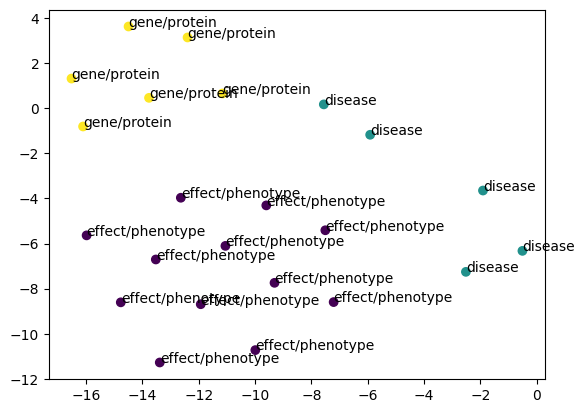

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(n_components=2, random_state=42, perplexity=15) # trial and error, 15 seems to be the cut off
# Get the embeddings and labels
embeddings = np.array([node.embedding for node in index_nodes])

reduced_embeddings = tsne.fit_transform(embeddings)
labels = [node.metadata['node_type'] for node in index_nodes]
# Convert labels to numerical values for coloring
label_to_num = {label: idx for idx, label in enumerate(set(labels))}
numeric_labels = [label_to_num[label] for label in labels]

reduced_embeddings = np.array(reduced_embeddings)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=numeric_labels, cmap='viridis')
for i, txt in enumerate(labels):
    plt.annotate(txt, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.show()


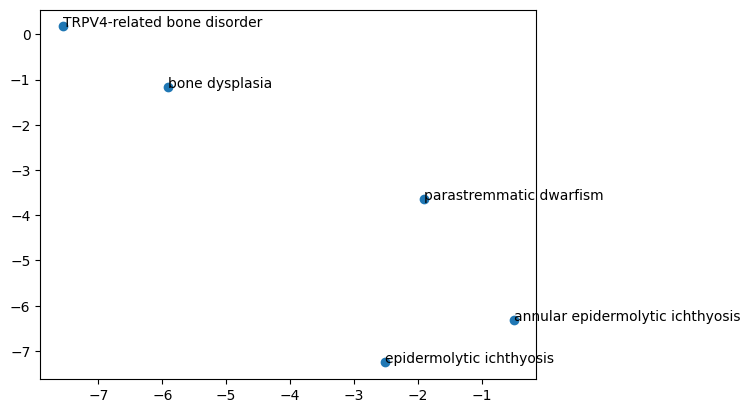

In [ ]:
# plot the embeddings according to the "node_type" = ' disease' from the "reduced_embeddings" variable
disease_embeddings = []
disease_labels = []
for i, node in enumerate(index_nodes):
    if node.metadata['node_type'] == 'disease':
        disease_embeddings.append(reduced_embeddings[i])
        disease_labels.append(node.metadata['node_name'])

#plot the embeddings
disease_embeddings = np.array(disease_embeddings)
plt.scatter(disease_embeddings[:, 0], disease_embeddings[:, 1])
for i, txt in enumerate(disease_labels):
    plt.annotate(txt, (disease_embeddings[i, 0], disease_embeddings[i, 1]))
plt.show()


### Semantic similarity VS metric similarity

semantic similarity:
1. genenerate embeddings from the 'node_name', these embeddings should capture relationships among the terms grouping similar closer together.
2. calculate pairwise cosine similarity/Eucleidian distance
    - (both methods agree on the most similar pair, which corresponds to the same pair in the graph)

?? should I apply dimensionality reduction

In [181]:
#extract all `node_names` from the `index_nodes` variable for the nodes with the `node_type` = 'disease'
disease_names = []
for node in index_nodes:
    if node.metadata['node_type'] == 'disease':
        disease_names.append(node.metadata['node_name'])

disease_names

['parastremmatic dwarfism',
 'bone dysplasia',
 'TRPV4-related bone disorder',
 'annular epidermolytic ichthyosis',
 'epidermolytic ichthyosis']

In [220]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Load a pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Replace with a biomedical model if needed

# Compute embeddings for node names
node_embeddings = model.encode(disease_names)

similarity = cosine_similarity(node_embeddings, node_embeddings)
np.fill_diagonal(similarity, 0)
max_sim = np.max(similarity)
max_idx = np.unravel_index(np.argmax(similarity), similarity.shape)
print(f"Max cosine similarity:", max_sim, (disease_names[max_idx[0]], disease_names[max_idx[1]]))

# Compute euclidean distances avoiding self-comparisons
distance = euclidean_distances(node_embeddings, node_embeddings)
np.fill_diagonal(distance, np.inf)
min_dist = np.min(distance)
min_idx = np.unravel_index(np.argmin(distance), distance.shape)
print(f"Min euclidean distance:", min_dist, (disease_names[min_idx[0]], disease_names[min_idx[1]]))

Max cosine similarity: 0.93267953 ('annular epidermolytic ichthyosis', 'epidermolytic ichthyosis')
Min euclidean distance: 0.36693457 ('annular epidermolytic ichthyosis', 'epidermolytic ichthyosis')


embeddings from the index:

In [272]:
similarity = cosine_similarity(disease_embeddings, disease_embeddings) #direct from the dimensionality reduction
np.fill_diagonal(similarity, 0)
max_sim = np.max(similarity)
max_idx = np.unravel_index(np.argmax(similarity), similarity.shape)
print(f"Max cosine similarity:", max_sim, (disease_labels[max_idx[0]], disease_labels[max_idx[1]]))

# Compute euclidean distances avoiding self-comparisons
distance = euclidean_distances(disease_embeddings, disease_embeddings)
np.fill_diagonal(distance, np.inf)
min_dist = distance.min()
min_idx = np.unravel_index(np.argmin(distance), distance.shape)
print(f"Min euclidean distance:", min_dist, (disease_labels[min_idx[0]], disease_labels[min_idx[1]]))


Max cosine similarity: 0.98910624 ('parastremmatic dwarfism', 'epidermolytic ichthyosis')
Min euclidean distance: 2.1278055 ('bone dysplasia', 'TRPV4-related bone disorder')


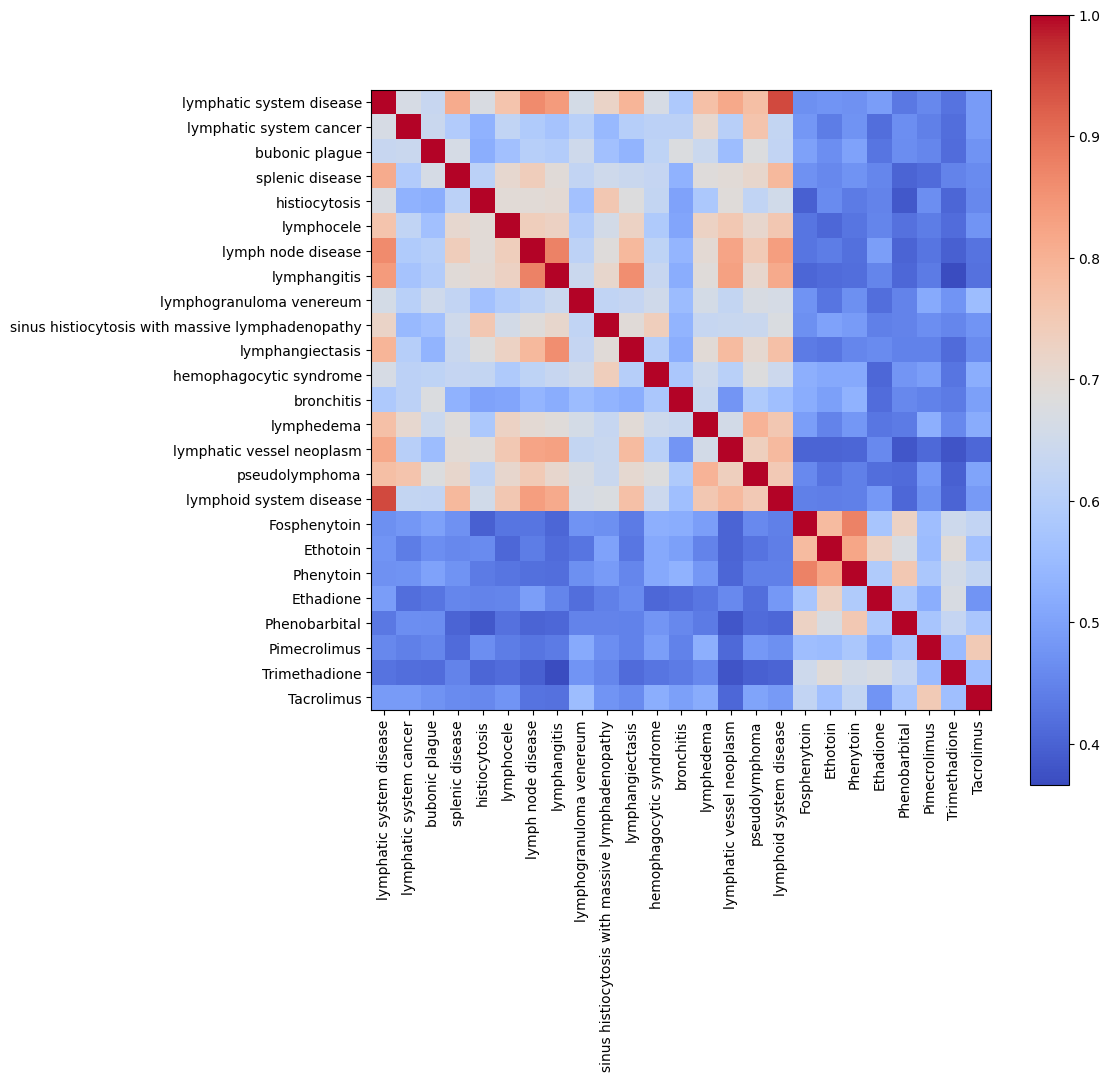

In [37]:
# calculate Pearson correlations among the embeddings in index_nodes
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

index_nodes_embeddings = np.array([node.embedding for node in index_nodes])
correlations = np.corrcoef(index_nodes_embeddings)

#plot half of the correlation matrix with labels and correlation values
plt.figure(figsize=(10, 10))
plt.imshow(correlations, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(index_nodes)), [node.metadata['node_name'] for node in index_nodes], rotation=90)
plt.yticks(range(len(index_nodes)), [node.metadata['node_name'] for node in index_nodes])
plt.show()



comparison of both:
-   between the distance from the 'node_name' and the distance from the index
- the distance value for the same pair should be similar: large distance for pairs distant in the index and in the 'node_name'